<font color=Blue size=12>US craft-beer data analysis.</font>

Beer is one of the most popular alcoholic beverage in the US. Beer available in the stores can be classified into roughly two camps: commercial high volume beer (think Budweiser or Miller) and Craft beer (think Dogfish Head, Six Point). 

High-volume beers tend to be cheaper, are less bitter, have lower alcohol content and are enjoyed by millions of people every day. Craft beers, on the other hand, have a lot more variety in bitterness, alcohol content, flavorings and tend to be more expensive. 

I downloaded a [dataset](https://www.kaggle.com/nickhould/craft-cans) from Kaggle which contains information about 2400+ craft beers and 550+ craft-breweries in the US. In this notebook I present the exploratory analysis of this dataset.

In [1]:
# Importing necessary libraries

import os #for elegant filepaths

import numpy as np #data manipulation
import pandas as pd

import matplotlib.pyplot as plt #data visualization
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import geopandas as gpd #Plotting geographical maps

import urllib3 # for scraping
from bs4 import BeautifulSoup #html parsing


#Basic ML libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [2]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(),'..')) #useful to remember this
ROOT_DIR

'/Users/NikhilStuff/Desktop/beer_data'

In [3]:
DATA_DIR = os.path.join(ROOT_DIR,'data')
print(DATA_DIR)

/Users/NikhilStuff/Desktop/beer_data/data


In [4]:
SHAPE_DIR = os.path.join(ROOT_DIR,'shape_files')
print(SHAPE_DIR)

/Users/NikhilStuff/Desktop/beer_data/shape_files


In [5]:
# beers file
fp1 = os.path.join(DATA_DIR, 'beers.csv')
beers = pd.read_csv(fp1, index_col=0)
beers['abv'] = beers['abv']*100
beers

abv   ibu    id                  name                           style  \
0     5.0   NaN  1436              Pub Beer             American Pale Lager   
1     6.6   NaN  2265           Devil's Cup         American Pale Ale (APA)   
2     7.1   NaN  2264   Rise of the Phoenix                    American IPA   
3     9.0   NaN  2263              Sinister  American Double / Imperial IPA   
4     7.5   NaN  2262         Sex and Candy                    American IPA   
...   ...   ...   ...                   ...                             ...   
2405  6.7  45.0   928             Belgorado                     Belgian IPA   
2406  5.2   NaN   807         Rail Yard Ale        American Amber / Red Ale   
2407  5.5   NaN   620       B3K Black Lager                     Schwarzbier   
2408  5.5  40.0   145   Silverback Pale Ale         American Pale Ale (APA)   
2409  5.2   NaN    84  Rail Yard Ale (2009)        American Amber / Red Ale   

      brewery_id  ounces  
0            408    12.0  
1            177    12.0  
2            177    12.0  
3            177    12.0  
4            177    12.0  
...          ...     ...  
2405         424    12.0  
2406         424    12.0  
2407         424    12.0  
2408         424    12.0  
2409         424    12.0  

[2410 rows x 7 columns]

In [6]:
#breweries file
fp2 = os.path.join(DATA_DIR, 'breweries.csv')
brews = pd.read_csv(fp2)
brews.rename(columns={brews.columns[0] : 'brewery_id'}, inplace=True)
brews['state'] = brews['state'].str.strip() 
brews

brewery_id                           name           city state
0             0             NorthGate Brewing     Minneapolis    MN
1             1      Against the Grain Brewery     Louisville    KY
2             2       Jack's Abby Craft Lagers     Framingham    MA
3             3      Mike Hess Brewing Company      San Diego    CA
4             4        Fort Point Beer Company  San Francisco    CA
..          ...                            ...            ...   ...
553         553            Covington Brewhouse      Covington    LA
554         554                Dave's Brewfarm         Wilson    WI
555         555          Ukiah Brewing Company          Ukiah    CA
556         556        Butternuts Beer and Ale  Garrattsville    NY
557         557  Sleeping Lady Brewing Company      Anchorage    AK

[558 rows x 4 columns]

## Exploring the beers 

In [7]:
styles = beers['style'].value_counts()*100/beers['style'].value_counts().sum()
print(f'Number of unique styles --> {styles.shape[0]}')
print('-'*50)
print('Top 5 most common styles')
print('-'*50)
display(styles.head())

Number of unique styles --> 99
--------------------------------------------------
Top 5 most common styles
--------------------------------------------------


American IPA                      17.629938
American Pale Ale (APA)           10.187110
American Amber / Red Ale           5.530146
American Blonde Ale                4.490644
American Double / Imperial IPA     4.365904
Name: style, dtype: float64

In [8]:
abv_by_style = beers.groupby('style')['abv'].mean().sort_values(ascending=False)
print('-'*50)
print('Top 5 most alcoholic styles of beer')
print('-'*50)
display(abv_by_style.head())

--------------------------------------------------
Top 5 most alcoholic styles of beer
--------------------------------------------------


style
English Barleywine        10.766667
Quadrupel (Quad)          10.400000
American Malt Liquor       9.900000
American Barleywine        9.900000
Russian Imperial Stout     9.763636
Name: abv, dtype: float64

In [9]:
ibu_by_style = beers.groupby('style')['ibu'].mean().sort_values(ascending=False)
print('-'*50)
print('Top 5 most bitter styles of beer')
print('-'*50)
display(ibu_by_style.head())


--------------------------------------------------
Top 5 most bitter styles of beer
--------------------------------------------------


style
American Barleywine                   96.00
American Double / Imperial IPA        93.32
Russian Imperial Stout                86.50
American Double / Imperial Pilsner    85.00
Belgian Strong Dark Ale               72.00
Name: ibu, dtype: float64

In [10]:
ibu_by_style.loc['American Pale Lager']

26.75

In [11]:
ibu_by_style.dropna().to_dict()['American Pale Lager']

26.75

## Missing data

In [12]:
print('Missing IBU data')
display(beers['ibu'].isna().value_counts())


Missing IBU data


False    1405
True     1005
Name: ibu, dtype: int64

In [13]:
print('Missing ABV data')
display(beers['abv'].isna().value_counts())

Missing ABV data


False    2348
True       62
Name: abv, dtype: int64

In [14]:
print('Missing style data')
display(beers['style'].isna().value_counts())

Missing style data


False    2405
True        5
Name: style, dtype: int64

## Imputing missing values
Imputing the data by using the avg values of abv and ibu for the style of beer. Note that 5 of the styles are missing. We will simply disregard those entries during the imputation process.

In [15]:
beers_imp = beers.copy()

In [16]:
def fill_missing(row):
    abv_dict = abv_by_style.to_dict()
    ibu_dict = ibu_by_style.to_dict()
    abv = row.abv
    ibu = row.ibu
    
    if not pd.isna(row.style):
        if pd.isna(row.abv):
            abv=abv_dict[row.style]
        
        if pd.isna(row.ibu):
            ibu=ibu_dict[row.style]
            
    return abv, ibu

tmp = beers_imp.apply(lambda x: fill_missing(x), axis=1).values

abv_list = list(zip(*tmp))[0]
ibu_list = list(zip(*tmp))[1]

In [17]:
beers_imp['abv'] = abv_list
beers_imp['ibu'] = ibu_list
beers_imp

abv        ibu    id                  name  \
0     5.0  26.750000  1436              Pub Beer   
1     6.6  44.941176  2265           Devil's Cup   
2     7.1  67.634551  2264   Rise of the Phoenix   
3     9.0  93.320000  2263              Sinister   
4     7.5  67.634551  2262         Sex and Candy   
...   ...        ...   ...                   ...   
2405  6.7  45.000000   928             Belgorado   
2406  5.2  36.298701   807         Rail Yard Ale   
2407  5.5  31.000000   620       B3K Black Lager   
2408  5.5  40.000000   145   Silverback Pale Ale   
2409  5.2  36.298701    84  Rail Yard Ale (2009)   

                               style  brewery_id  ounces  
0                American Pale Lager         408    12.0  
1            American Pale Ale (APA)         177    12.0  
2                       American IPA         177    12.0  
3     American Double / Imperial IPA         177    12.0  
4                       American IPA         177    12.0  
...                              ...         ...     ...  
2405                     Belgian IPA         424    12.0  
2406        American Amber / Red Ale         424    12.0  
2407                     Schwarzbier         424    12.0  
2408         American Pale Ale (APA)         424    12.0  
2409        American Amber / Red Ale         424    12.0  

[2410 rows x 7 columns]

In [18]:
beers_imp['ibu'].isna().value_counts()

False    2355
True       55
Name: ibu, dtype: int64

In [19]:
beers_imp['abv'].isna().value_counts()

False    2407
True        3
Name: abv, dtype: int64

In [20]:
#Plotting scatter plot of 5 most common beer styles
N=15
styles = beers_imp['style'].value_counts().sort_values(ascending=False)
top_N_styles = styles.head(N).index.to_list()
popular_beers = beers[beers['style'].isin(top_N_styles)]
popular_beers

abv   ibu    id                         name  \
0     5.0   NaN  1436                     Pub Beer   
1     6.6   NaN  2265                  Devil's Cup   
2     7.1   NaN  2264          Rise of the Phoenix   
3     9.0   NaN  2263                     Sinister   
4     7.5   NaN  2262                Sex and Candy   
...   ...   ...   ...                          ...   
2400  6.0  50.0  1511                  Worthy Pale   
2404  7.5   NaN  1035  Rocky Mountain Oyster Stout   
2406  5.2   NaN   807                Rail Yard Ale   
2408  5.5  40.0   145          Silverback Pale Ale   
2409  5.2   NaN    84         Rail Yard Ale (2009)   

                               style  brewery_id  ounces  
0                American Pale Lager         408    12.0  
1            American Pale Ale (APA)         177    12.0  
2                       American IPA         177    12.0  
3     American Double / Imperial IPA         177    12.0  
4                       American IPA         177    12.0  
...                              ...         ...     ...  
2400         American Pale Ale (APA)         199    12.0  
2404                  American Stout         424    12.0  
2406        American Amber / Red Ale         424    12.0  
2408         American Pale Ale (APA)         424    12.0  
2409        American Amber / Red Ale         424    12.0  

[1562 rows x 7 columns]

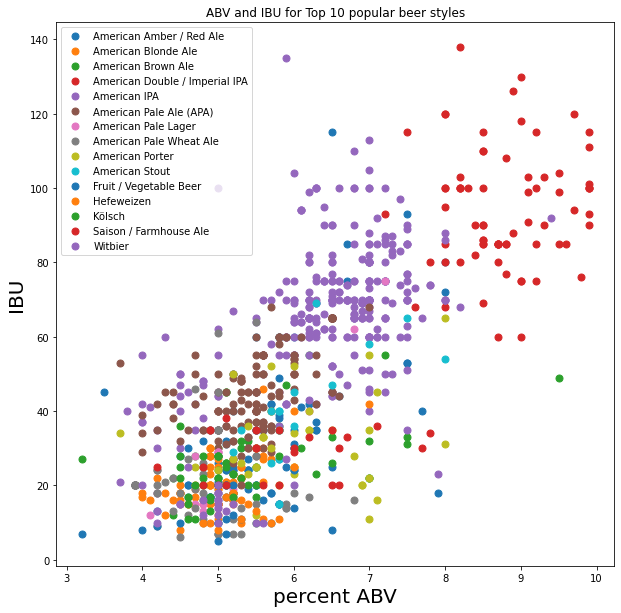

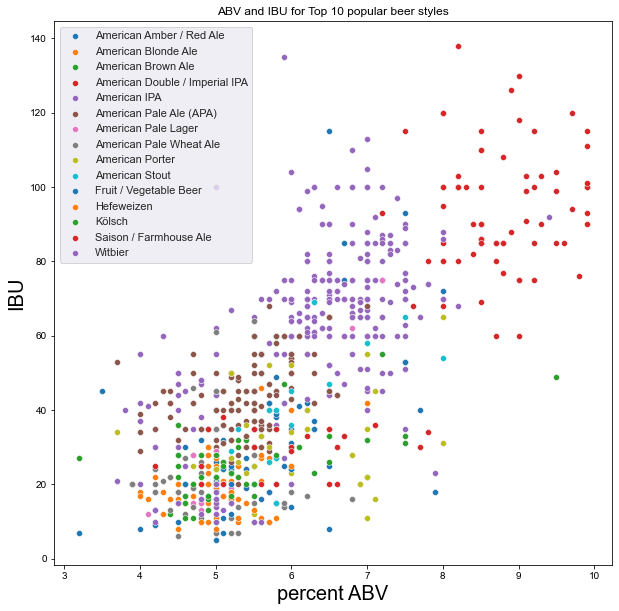

In [21]:
# Barebones Matplotlib
fig, ax = plt.subplots(1,1, figsize=(10,10))
groups = popular_beers.dropna().groupby('style')

for name, group in groups:
    ax.plot(group.abv, group.ibu, marker='o', linestyle='', markersize=7, label=name)
    ax.legend()
    ax.set_xlabel('percent ABV', size=20)
    ax.set_ylabel('IBU', size=20)
    ax.set_title('ABV and IBU for Top 10 popular beer styles')
plt.show()

# Seaborn
fig, ax = plt.subplots(1,1, figsize=(10,10))
groups = popular_beers.dropna().groupby('style')

sns.set_theme(style="darkgrid")

for name, group in groups:
    sns.scatterplot(x=group.abv, y=group.ibu, ax=ax, marker='o', label=name, palette='fivethirtyeight')
    ax.set_xlabel('percent ABV', size=20)
    ax.set_ylabel('IBU', size=20)
    ax.set_title('ABV and IBU for Top 10 popular beer styles')
plt.show()

#Plotly.Express
fig = px.scatter(data_frame=popular_beers,
                 x="abv", 
                 y="ibu",
                color='style',
                width=512*1.5,
                height=512)
fig.show()



## Trying to find similar beer types using unsupervised clustering

In [22]:
X = beers.dropna()[['abv','ibu']].values
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_X)

In [23]:
kmeans.labels_

array([1, 3, 2, ..., 0, 0, 0], dtype=int32)

In [24]:
beers_classes = beers.dropna().copy()
beers_classes['kmeans_class'] = kmeans.labels_
beers_classes.sample(5)

abv   ibu    id                         name  \
1671  6.0  15.0  1462              Dead Eye Dunkel   
865   5.5  18.0  1208  Twisted Helles Summer Lager   
335   6.6  72.0  2422   Firestarter India Pale Ale   
545   5.9  22.0  2255               Santa's Secret   
1596  8.7  60.0   733           Gordon Beer (2006)   

                               style  brewery_id  ounces  kmeans_class  
1671             Munich Dunkel Lager         135    12.0             4  
865              Munich Helles Lager         253    12.0             4  
335                     American IPA         107    12.0             1  
545                    Winter Warmer         179    16.0             4  
1596  American Double / Imperial IPA         503    12.0             3

In [25]:
beers_classes[beers_classes['kmeans_class']==0]['style'].value_counts().head(5)

American Pale Ale (APA)                115
American IPA                            53
American Amber / Red Ale                30
American Porter                         19
Extra Special / Strong Bitter (ESB)     12
Name: style, dtype: int64

In [26]:
beers_classes[beers_classes['kmeans_class']==1]['style'].value_counts().head(5)

American IPA                228
American Pale Ale (APA)      19
American Black Ale           13
American Strong Ale           9
American Amber / Red Ale      7
Name: style, dtype: int64

In [27]:
beers_classes[beers_classes['kmeans_class']==2]['style'].value_counts().head(5)

Scotch Ale / Wee Heavy    11
American Porter            9
American IPA               8
Scottish Ale               7
American Brown Ale         7
Name: style, dtype: int64

In [28]:
beers_classes[beers_classes['kmeans_class']==3]['style'].value_counts().head(5)

American Double / Imperial IPA    70
Russian Imperial Stout             8
American Black Ale                 4
American IPA                       3
English Barleywine                 3
Name: style, dtype: int64

In [29]:
beers_classes[beers_classes['kmeans_class']==4]['style'].value_counts().head(5)

American Blonde Ale         53
American Pale Wheat Ale     52
American Amber / Red Ale    35
Fruit / Vegetable Beer      27
Hefeweizen                  25
Name: style, dtype: int64

In the following cell we map the style of the beer to the class assigned to it by the KMeans classifier

In [30]:
classification =(beers_classes
 .groupby('style')['kmeans_class']
 .value_counts(ascending=False)
 .to_frame()
 .rename(columns={'kmeans_class' :'counts'})
 .reset_index(level='kmeans_class')
 .groupby('style')['kmeans_class']
 .nth(0)
 .to_frame()
 .reset_index())

In [31]:
classification

style  kmeans_class
0             Abbey Single Ale             4
1                      Altbier             0
2       American Adjunct Lager             4
3     American Amber / Red Ale             4
4   American Amber / Red Lager             4
..                         ...           ...
85                      Tripel             2
86                Vienna Lager             4
87                   Wheat Ale             0
88               Winter Warmer             2
89                     Witbier             4

[90 rows x 2 columns]

In [32]:
classification[classification['kmeans_class']==2]['style']

23          American Wild Ale
25           Belgian Dark Ale
29    Belgian Strong Pale Ale
31             Bière de Garde
37                 Doppelbock
39                     Dubbel
49         English Strong Ale
66      Maibock / Helles Bock
72                    Old Ale
75           Quadrupel (Quad)
82     Scotch Ale / Wee Heavy
83               Scottish Ale
85                     Tripel
88              Winter Warmer
Name: style, dtype: object

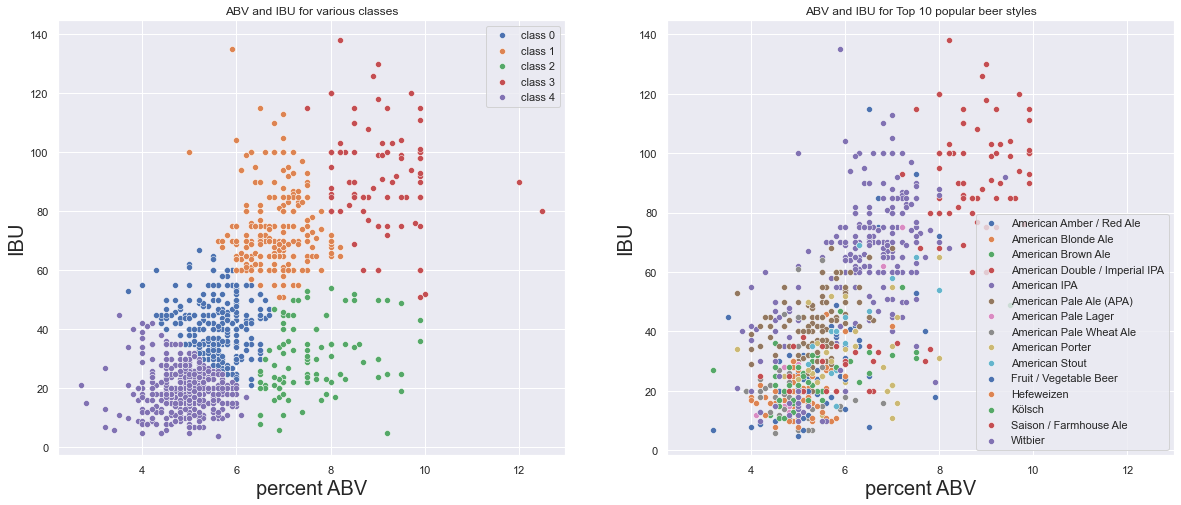

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
groups_1 = beers_classes.dropna().groupby('kmeans_class')

for name, group in groups_1:
#     ax1.plot(group.abv, 
#              group.ibu,
#              marker='o', 
#              linestyle='', 
#              markersize=7, 
#              label=f'class {name}'
#             )
#     ax1.legend()
    sns.scatterplot(x=group.abv, 
             y=group.ibu,
             marker='o', 
             ax=ax1,
             label=f'class {name}'
            )
    ax1.legend()
    ax1.set_xlabel('percent ABV', size=20)
    ax1.set_ylabel('IBU', size=20)
    ax1.set_title('ABV and IBU for various classes')
    
groups_2 = popular_beers.dropna().groupby('style')

for name, group in groups_2:
#     ax2.plot(group.abv,
#              group.ibu,
#              marker='o', 
#              linestyle='',
#              markersize=7,
#              label=name)
#     ax2.legend()
    sns.scatterplot(x=group.abv,
             y=group.ibu,
             marker='o', 
             ax=ax2,
             label=name)
    ax2.set_xlabel('percent ABV', size=20)
    ax2.set_ylabel('IBU', size=20)
    ax2.set_title('ABV and IBU for Top 10 popular beer styles')
    ax2.set_xlim(ax1.get_xlim())

plt.show()


In [34]:
#Plotly.Express
fig = px.scatter(data_frame=popular_beers.dropna(),
                 x="abv", 
                 y="ibu",
                color='style',
                width=512*1.5,
                height=512)
fig.show()

fig = px.scatter(data_frame=beers_classes.dropna(),
                 x="abv", 
                 y="ibu",
                color='kmeans_class',
                width=512*1.2,
                height=512)
fig.show()

The above plot shows that the 
- class 0 corresponds to American Pale Ale
- class 1 corresponds to American IPA
- class 2 corresponds to miscellaneous European ales
- class 3 corresponds to American Double/Imperial IPA
- class 4 corresponds to Witbier, American Blonde Ale and American Pale Wheat Ale, Kolsch

## Exploring breweries

In [35]:
prolific_brewers = beers['brewery_id'].value_counts()

brews_dict = brews['name'].to_dict() #used to map brewery_id to brewery_name

prolific_brewers = (prolific_brewers
                    .reset_index()
                    .rename(columns = {'index' : 'brewery', 'brewery_id': 'num_beers'}))

prolific_brewers['brewery']= prolific_brewers['brewery'].map(brews_dict)

pb = prolific_brewers.merge(brews, left_on ='brewery', right_on='name', how='left')
pb.drop(['brewery', 'brewery_id'], axis=1,inplace=True)
print('-'*50)
print('Top 10 prolific breweries')
print('-'*50)
display(pb.head(10))

--------------------------------------------------
Top 10 prolific breweries
--------------------------------------------------


num_beers                        name           city state
0         62              Brewery Vivant   Grand Rapids    MI
1         38    Sun King Brewing Company   Indianapolis    IN
2         33         Oskar Blues Brewery       Longmont    CO
3         33         Oskar Blues Brewery          Lyons    CO
4         25  Cigar City Brewing Company          Tampa    FL
5         24         Sixpoint Craft Ales       Brooklyn    NY
6         23      Hopworks Urban Brewery       Portland    OR
7         22       Stevens Point Brewery  Stevens Point    WI
8         20      Great Crescent Brewery         Aurora    IN
9         20      21st Amendment Brewery  San Francisco    CA

## brewery locations

In [36]:
brews_by_state = brews['state'].value_counts()
brews_by_state = (brews_by_state
                  .to_frame()
                  .reset_index()
                  .rename(columns = {'index':'state', 'state': 'num_brews'}))

brews_by_state.head()

state  num_brews
0    CO         47
1    CA         39
2    MI         32
3    OR         29
4    TX         28

In [37]:
brews['city'].value_counts().head(20)

Portland         17
Boulder           9
Chicago           9
Seattle           9
Denver            8
San Diego         8
Austin            8
Bend              6
San Francisco     5
Brooklyn          4
Cincinnati        4
Indianapolis      4
Columbus          4
Anchorage         4
Grand Rapids      3
Cleveland         3
Aurora            3
Baltimore         3
Edwards           3
Athens            3
Name: city, dtype: int64

In [38]:
fp3 = os.path.join(SHAPE_DIR, "cb_2018_us_state_20m.shp")
df_shape = gpd.read_file(fp3) #remember that this is a geopandas df

In [39]:
df_shape.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...

In [40]:
df_shape.drop(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER'], axis=1, inplace=True)


In [41]:
df_shape.sample(5)

STUSPS                                           geometry
49     NH  POLYGON ((-72.55611 42.86625, -72.53147 42.897...
30     MA  MULTIPOLYGON (((-70.27553 41.31046, -70.19371 ...
23     ID  POLYGON ((-117.24303 44.39097, -117.21507 44.4...
7      PR  MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ...
4      PA  POLYGON ((-80.51989 40.90666, -80.51964 40.987...

In [42]:
merged = df_shape.merge(brews_by_state, left_on='STUSPS', right_on='state')

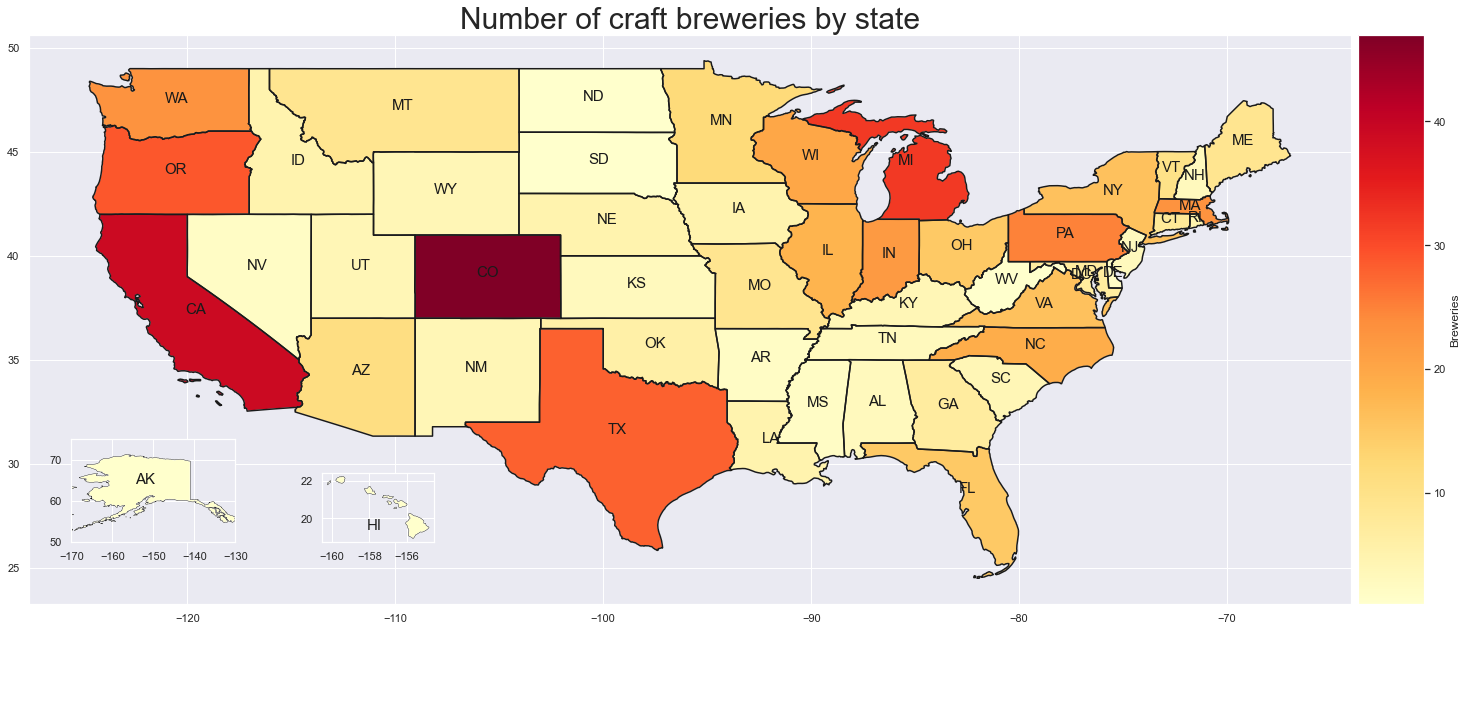

In [43]:
fig, ax = plt.subplots(figsize=(25,25))


# cmap = 'OrRd'
cmap = 'YlOrRd'

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

axins1 = inset_axes(ax, width='30%', height='30%', loc='lower left', bbox_to_anchor=(0,0.1,0.6,0.6), bbox_transform=ax.transAxes)
axins2 = inset_axes(ax, width='20%', height='20%', loc='lower left', bbox_to_anchor=(0.2,0.1,0.6,0.6), bbox_transform=ax.transAxes)

#--------Mainland contiguous USA-------
merged[~(merged['state']=='AK') & ~(merged['state']=='HI')].plot(column ='num_brews', 
            ax=ax, 
            cax=cax,
            cmap=cmap,
            legend=True,
            legend_kwds={'label':'Breweries'})

merged[~(merged['state']=='AK') & ~(merged['state']=='HI')].boundary.plot(ax=ax, color='k')

df_shape[~(df_shape['STUSPS']=='AK') & ~(df_shape['STUSPS']=='HI')].apply(lambda x: ax.annotate(
    text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=15, color='k'),axis=1);


# --------Alaska--------
merged[merged['state']=='AK'].plot(column ='num_brews', 
            ax=axins1,                 
            cmap=cmap)
df_shape[df_shape['STUSPS']=='AK'].boundary.plot(ax=axins1, color='Black', linewidth=.4)

(df_shape[df_shape['STUSPS']=='AK'].apply(lambda x: 
                                          axins1.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0], 
                                                         ha='center', fontsize=15, color='k'),axis=1))

# --------Hawaii--------
merged[merged['state']=='HI'].plot(column ='num_brews', 
            ax=axins2,
            cmap=cmap)
df_shape[df_shape['STUSPS']=='HI'].boundary.plot(ax=axins2, color='Black', linewidth=.4)

(df_shape[df_shape['STUSPS']=='HI'].apply(lambda xx: 
                                          axins2.annotate(text=xx.STUSPS, xy=(xx.geometry.centroid.x-1,xx.geometry.centroid.y-1), 
                                                         ha='right',va='bottom', fontsize=15, color='k'),axis=1))


axins1.set_xlim(-170,-130)
axins1.set_ylim(50,75) #Has to be done because Alaska has a small tail in the eastern hemisphere

ax.set_title('Number of craft breweries by state', size=30)
ax.set_aspect('equal')


plt.show()

In [44]:
fig = go.Figure(data=go.Choropleth(
    locations=merged['state'], # Spatial coordinates
    z = merged['num_brews'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Viridis',
    colorbar_title = f"#breweries",
))

fig.update_layout(
    title_text = 'US craft breweries by State (as of 2017)',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In order to show the location of individual cities on the map, we need the latitude and longitude information. I did this by downloading the freely available csv from [this](https://simplemaps.com/data/us-cities) website.

In [45]:
def generate_url(city,state):
    url = "http://www.geonames.org/search.html?q="
    city = city.replace(' ','+')
    url += city
    url += "%2C+"
    url += state
    url += '&country=US'
    return url

def get_latlon(city, state):
    http = urllib3.PoolManager()
    r = http.request('GET', generate_url(city,state))
    html_doc = r.data
    soup = BeautifulSoup(html_doc, 'html.parser')
    try:
        lon = float(soup.find_all('span', class_="longitude")[0].text)
        lat = float(soup.find_all('span', class_="latitude")[0].text)
        return lat,lon
    except IndexError as e:
        print(f'could not find {city}, {state}')
        return np.nan, np.nan
    
    


In [46]:
get_latlon('Woodbridge','CT')

(41.352597, -73.0084385)

In [47]:
get_latlon('South Woodstock','CT')

(41.9389864, -71.9595179)

In [48]:
get_latlon('Minneapolis', 'MN')

(44.9799654, -93.2638361)

In [49]:
#Fixing typos in hindsight
brews['city'] = brews['city'].str.replace('Mt. Airy', 'Mount Airy')
brews['city'] = brews['city'].str.replace('Northamtpon','Northampton')
brews['city'] = brews['city'].str.replace('Bucryus','Bucyrus')

/Users/NikhilStuff/anaconda3/envs/beer/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [50]:
%%time
fp4 = os.path.join(DATA_DIR, 'brews.csv')
if(os.path.exists(fp4)):
    brews = pd.read_csv(fp4, index_col=0)
    brews['geometry'] = gpd.points_from_xy(brews['lon'],brews['lat'])
    brews_gdf = gpd.GeoDataFrame(brews, geometry=brews['geometry'])
else:
    tmp = brews.apply(lambda x: get_latlon(x.city,x.state),axis=1)
    lats=list(zip(*tmp))[0]
    lons=list(zip(*tmp))[1]
    brews['lat'] = lats
    brews['lon'] = lons
    brews['geometry'] = gpd.points_from_xy(brews['lon'],brews['lat'])
    brews_gdf =gpd.GeoDataFrame(brews, geometry=brews['geometry'])
    brews_gdf.to_csv(os.path.join(DATA_DIR, 'brews.csv'))
brews_gdf

CPU times: user 34.3 ms, sys: 6.54 ms, total: 40.8 ms
Wall time: 48.3 ms


brewery_id                           name           city state  \
0             0             NorthGate Brewing     Minneapolis    MN   
1             1      Against the Grain Brewery     Louisville    KY   
2             2       Jack's Abby Craft Lagers     Framingham    MA   
3             3      Mike Hess Brewing Company      San Diego    CA   
4             4        Fort Point Beer Company  San Francisco    CA   
..          ...                            ...            ...   ...   
553         553            Covington Brewhouse      Covington    LA   
554         554                Dave's Brewfarm         Wilson    WI   
555         555          Ukiah Brewing Company          Ukiah    CA   
556         556        Butternuts Beer and Ale  Garrattsville    NY   
557         557  Sleeping Lady Brewing Company      Anchorage    AK   

           lat         lon                     geometry  
0    44.979965  -93.263836   POINT (-93.26384 44.97997)  
1    38.303081  -85.682219   POINT (-85.68222 38.30308)  
2    42.279263  -71.416172   POINT (-71.41617 42.27926)  
3    32.715710 -117.164720  POINT (-117.16472 32.71571)  
4    37.774929 -122.419415  POINT (-122.41942 37.77493)  
..         ...         ...                          ...  
553  31.005180  -86.328002   POINT (-86.32800 31.00518)  
554  44.953575  -92.173518   POINT (-92.17352 44.95358)  
555  39.433624 -123.431554  POINT (-123.43155 39.43362)  
556  42.647297  -75.171831   POINT (-75.17183 42.64730)  
557  61.218056 -149.900278  POINT (-149.90028 61.21806)  

[558 rows x 7 columns]

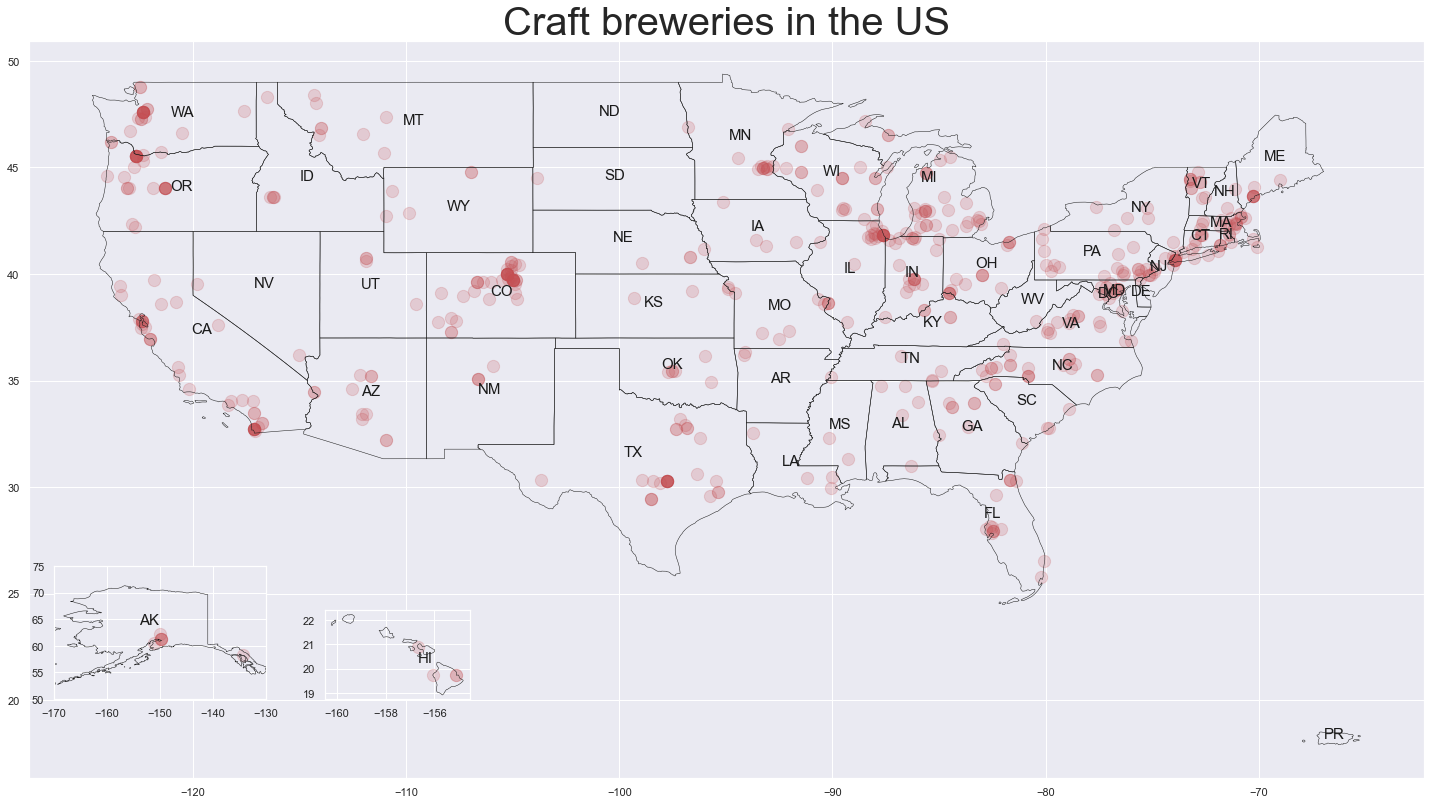

In [51]:
fig, ax = plt.subplots(figsize=(25,25))

axins1 = inset_axes(ax, width='30%', height='30%', loc='lower left', bbox_to_anchor=(0,0.1,0.6,0.6), bbox_transform=ax.transAxes)
axins2 = inset_axes(ax, width='20%', height='20%', loc='lower left', bbox_to_anchor=(0.2,0.1,0.6,0.6), bbox_transform=ax.transAxes)



df_shape[~(df_shape['STUSPS']=='AK') & ~(df_shape['STUSPS']=='HI')].apply(lambda x: ax.annotate(
    text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=15, color='k'),axis=1);
df_shape[(df_shape['STUSPS']=='AK')].apply(lambda x: axins1.annotate(
    text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=15, color='k'),axis=1);
df_shape[(df_shape['STUSPS']=='HI')].apply(lambda x: axins2.annotate(
    text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=15, color='k'),axis=1);


lw=0.5
df_shape[~(df_shape['STUSPS']=='AK') & ~(df_shape['STUSPS']=='HI')].boundary.plot(ax=ax, color='k', linewidth=lw)
df_shape[(df_shape['STUSPS']=='AK')].boundary.plot(ax=axins1, color='k', linewidth=lw)
df_shape[(df_shape['STUSPS']=='HI')].boundary.plot(ax=axins2, color='k', linewidth=lw)



brews_gdf[~(brews_gdf['state']=='AK') & ~(brews_gdf['state']=='HI')].plot(ax=ax, marker = 'o', markersize=150, color='r',alpha=0.2)
brews_gdf[brews_gdf['state']=='AK'].plot(ax=axins1, marker = 'o', markersize=150, color='r',alpha=0.2)
brews_gdf[brews_gdf['state']=='HI'].plot(ax=axins2, marker = 'o', markersize=150, color='r',alpha=0.2)

ax.set_title('Craft breweries in the US', size=40)

axins1.set_xlim(-170,-130)
axins1.set_ylim(50,75) #Has to be done because Alaska has a small tail in the eastern hemisphere


plt.show()

# Ratings data from Beer Advocate
I simply copied the top rated beers data from [beerAdvocate](https://www.beeradvocate.com/beer/popular/) and saved it using excel as a csv file. It needs to be cleaned, which I do below.

In [52]:
fp5 = os.path.join(DATA_DIR, 'beerAdvocate_popular.csv')
ba_popular = pd.read_csv(fp5)
ba_popular.head()

id                 description Ratings   Avg
0  1.0             Breakfast Stout  17,744  4.55
1  NaN    Founders Brewing Company     NaN   NaN
2  NaN     Stout - Oatmeal | 8.30%     NaN   NaN
3  2.0               90 Minute IPA  16,337  4.30
4  NaN  Dogfish Head Craft Brewery     NaN   NaN

In [53]:
ba_popular['id'].ffill(inplace=True)

In [54]:
beer_name = ba_popular.groupby('id').nth(0).description.values
brewery_name = ba_popular.groupby('id').nth(1).description.values
beer_style,beer_abv = zip(*(ba_popular.groupby('id').nth(2).description.str.split('|').values))

In [55]:
ba_popular[['Ratings', 'Avg']].dropna()

Ratings   Avg
0    17,744  4.55
3    16,337  4.30
6    15,536  4.30
9    15,436  4.69
12   14,953  4.76
..      ...   ...
735   3,565  4.06
738   3,547  3.90
741   3,535  3.32
744   3,520  4.16
747   3,505  4.08

[250 rows x 2 columns]

In [56]:
tmp = pd.DataFrame(data = {'beer_name': beer_name, 'brewery_name' : brewery_name,
                           'beer_style': beer_style,
                           'beer_abv': beer_abv})

In [57]:
tmp

beer_name  \
0              Breakfast Stout   
1                90 Minute IPA   
2              Two Hearted Ale   
3              Pliny The Elder   
4                 Heady Topper   
..                         ...   
245                  Pranqster   
246                Liberty Ale   
247                Purple Haze   
248  Shakespeare Oatmeal Stout   
249                      Stout   

                                        brewery_name  \
0                           Founders Brewing Company   
1                         Dogfish Head Craft Brewery   
2    Bell's Brewery - Eccentric Café & General Store   
3                      Russian River Brewing Company   
4                                      The Alchemist   
..                                               ...   
245                          North Coast Brewing Co.   
246                           Anchor Brewing Company   
247                                Abita Brewing Co.   
248                                       Rogue Ales   
249                        Sierra Nevada Brewing Co.   

                     beer_style beer_abv  
0              Stout - Oatmeal     8.30%  
1               IPA - Imperial     9.00%  
2               IPA - American     7.00%  
3               IPA - Imperial     8.00%  
4            IPA - New England     8.00%  
..                          ...      ...  
245  Strong Ale - Belgian Pale     7.60%  
246             IPA - American     5.90%  
247       Fruit and Field Beer     4.20%  
248            Stout - Oatmeal     5.80%  
249           Stout - American     5.80%  

[250 rows x 4 columns]

In [58]:
ba_popular = pd.concat((tmp,ba_popular[['Ratings', 'Avg']].dropna().reset_index(drop=True)), axis=1)

In [59]:
ba_popular

beer_name  \
0              Breakfast Stout   
1                90 Minute IPA   
2              Two Hearted Ale   
3              Pliny The Elder   
4                 Heady Topper   
..                         ...   
245                  Pranqster   
246                Liberty Ale   
247                Purple Haze   
248  Shakespeare Oatmeal Stout   
249                      Stout   

                                        brewery_name  \
0                           Founders Brewing Company   
1                         Dogfish Head Craft Brewery   
2    Bell's Brewery - Eccentric Café & General Store   
3                      Russian River Brewing Company   
4                                      The Alchemist   
..                                               ...   
245                          North Coast Brewing Co.   
246                           Anchor Brewing Company   
247                                Abita Brewing Co.   
248                                       Rogue Ales   
249                        Sierra Nevada Brewing Co.   

                     beer_style beer_abv Ratings   Avg  
0              Stout - Oatmeal     8.30%  17,744  4.55  
1               IPA - Imperial     9.00%  16,337  4.30  
2               IPA - American     7.00%  15,536  4.30  
3               IPA - Imperial     8.00%  15,436  4.69  
4            IPA - New England     8.00%  14,953  4.76  
..                          ...      ...     ...   ...  
245  Strong Ale - Belgian Pale     7.60%   3,565  4.06  
246             IPA - American     5.90%   3,547  3.90  
247       Fruit and Field Beer     4.20%   3,535  3.32  
248            Stout - Oatmeal     5.80%   3,520  4.16  
249           Stout - American     5.80%   3,505  4.08  

[250 rows x 6 columns]

In [60]:
ba_popular['beer_style'].value_counts()

IPA - American                40
IPA - Imperial                26
Stout - American Imperial     22
Stout - Russian Imperial      11
Pale Ale - American            8
                              ..
Lager - Vienna                 1
Bock - Doppelbock              1
Barleywine - American          1
Sour - Berliner Weisse         1
Bock - Maibock                 1
Name: beer_style, Length: 64, dtype: int64

In [61]:
ba_popular['beer_abv']= ba_popular['beer_abv'].str.strip().str.replace('%','').astype(float)

In [62]:
ba_popular['beer_abv'].mean()

7.651280000000001

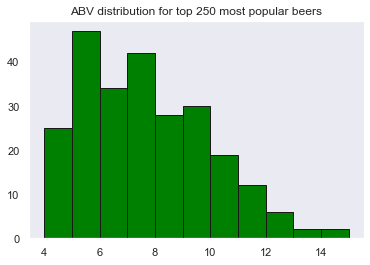

In [63]:
ba_popular['beer_abv'].hist(bins=range(4,16,1),fill=True, grid=False,color='green', edgecolor='k')
plt.title('ABV distribution for top 250 most popular beers')
plt.show()

### Are more alcoholic beers rated higher?

In [64]:
ba_popular.rename(columns = {'Avg' :'Avg_Rating'},inplace=True)
ba_popular.corr()

beer_abv  Avg_Rating
beer_abv    1.000000    0.520278
Avg_Rating  0.520278    1.000000

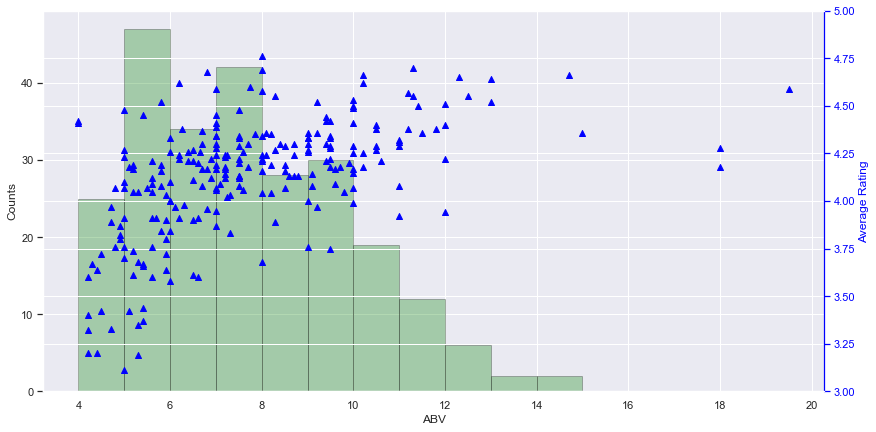

In [65]:
fig, ax1 = plt.subplots(figsize=(14,7))
ax2=ax1.twinx()
ax1.hist(ba_popular['beer_abv'],bins=range(4,16,1),fill=True,color='green', edgecolor='k', alpha=0.3)
ax2.scatter(x=ba_popular['beer_abv'], y=ba_popular['Avg_Rating'], c='blue',marker='^')
ax1.set_xlabel('ABV')
ax1.set_ylabel('Counts')
ax2.set_ylabel('Average Rating')
ax2.set_ylim(3,5)

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.spines['right'].set_color('blue')

plt.show()

In [66]:
ba_popular['beer_name']

0                Breakfast Stout
1                  90 Minute IPA
2                Two Hearted Ale
3                Pliny The Elder
4                   Heady Topper
                 ...            
245                    Pranqster
246                  Liberty Ale
247                  Purple Haze
248    Shakespeare Oatmeal Stout
249                        Stout
Name: beer_name, Length: 250, dtype: object

In [67]:
beers['name']

0                   Pub Beer
1                Devil's Cup
2        Rise of the Phoenix
3                   Sinister
4              Sex and Candy
                ...         
2405               Belgorado
2406           Rail Yard Ale
2407         B3K Black Lager
2408     Silverback Pale Ale
2409    Rail Yard Ale (2009)
Name: name, Length: 2410, dtype: object

In [68]:
unknown = [beer for beer in ba_popular['beer_name'] if beer not in beers['name']]

In [69]:
len(unknown)

250

In [70]:
'Rail Yard Ale' in ba_popular['beer_name'].values

False

In [71]:
ba_popular['beer_name'][ba_popular['beer_name'].str.contains('21')]

Series([], Name: beer_name, dtype: object)

In [72]:
beers[['name','style']][beers['name'].str.contains('Dog')]

name                           style
244                    Gerry Dog Stout                  American Stout
763                          Lucky Dog         American Pale Ale (APA)
814                      Snake Dog IPA                    American IPA
1071                          Pale Dog         American Pale Ale (APA)
1195            Laughing Dog Cream Ale                       Cream Ale
1197                  Laughing Dog IPA                    American IPA
1279        Cant Dog Imperial Pale Ale  American Double / Imperial IPA
1776               Dog Days Summer Ale                          Kölsch
1827  Sea Dog Wild Blueberry Wheat Ale          Fruit / Vegetable Beer
2238                    Dog Days Lager       Dortmunder / Export Lager

In [73]:
ba_popular['beer_name'][ba_popular['brewery_name'].str.contains('Dog')]

1          90 Minute IPA
10         60 Minute IPA
32        120 Minute IPA
63            Punkin Ale
70          Burton Baton
84      Indian Brown Ale
91     Palo Santo Marron
131     World Wide Stout
134          Midas Touch
135              ApriHop
170        Festina Pêche
177        Raison D'Être
191         Raging Bitch
228        75 Minute IPA
Name: beer_name, dtype: object